In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import plot_importance
from xgboost import plot_tree
import lightgbm as lgb

Matplotlib created a temporary config/cache directory at /var/folders/_n/4rn71s9d0kbcfsx7vgnkblrc0000gn/T/matplotlib-79wx53lq because the default path (/Users/zhenhan/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
train = pd.read_csv("/Users/zhenhan/Desktop/深度学习/data/房屋数据（2011.8-2015.6）.csv")
train_isna = []
for col in train.columns:
    if train[col].isna().sum() / train.shape[0] > 0.4:
        train_isna.append(col)
df = train.drop(train_isna, axis=1)
df_num = df.select_dtypes(include=['int64', 'float64'])
df_obj = df.select_dtypes(include=['object'])
df_num_means = df_num.median()
df_num = df_num.fillna(df_num_means)
df_num.isna().sum().value_counts()
df_num = df_num.iloc[:,1:]
df_obj = df_obj.iloc[:,1:]
df_obj_map = {"poor":0, "no data":2, "satisfactory":2, "good":3, "excellent":4}
df_obj["ecology"] = df_obj["ecology"].map(df_obj_map)
label_encoder = LabelEncoder()
df_obj['sub_area'] = label_encoder.fit_transform(df_obj['sub_area'])
df_obj = pd.get_dummies(df_obj, columns=df_obj.columns[2:14], prefix=df_obj.columns[2:14])
df_obj = pd.get_dummies(df_obj, columns=['product_type'], prefix=['product_type'])
target_column = df_num.columns[-1]
# for col in df_num.columns:
#     correlation = df[col].corr(df[target_column])
#     if abs(correlation) <= 0.05:
#         df_num = df_num.drop(col, axis=1)
data = pd.concat([df_num, df_obj], axis=1)
X = data.drop('price_doc', axis=1)
y = data['price_doc']
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.66, random_state=42)

[0]	train-rmse:8330905.61310	val-rmse:8089590.38563
[20]	train-rmse:4316000.35871	val-rmse:4346813.65243
[40]	train-rmse:2688592.43518	val-rmse:3049725.30026
[60]	train-rmse:2074487.66255	val-rmse:2676511.57398
[80]	train-rmse:1826579.71988	val-rmse:2579008.38554
[100]	train-rmse:1707455.41945	val-rmse:2553940.60326
[120]	train-rmse:1621136.99544	val-rmse:2543281.41096
[140]	train-rmse:1565743.38991	val-rmse:2538582.19959
[160]	train-rmse:1513858.02165	val-rmse:2536088.25103
[180]	train-rmse:1469344.18702	val-rmse:2533471.91649
[200]	train-rmse:1429810.80676	val-rmse:2531622.94178
[220]	train-rmse:1389606.98047	val-rmse:2532135.83427
[240]	train-rmse:1348330.26034	val-rmse:2534974.73736
[260]	train-rmse:1311471.47769	val-rmse:2535212.24289
[271]	train-rmse:1296404.67391	val-rmse:2535459.57858
Root Mean Squared Error: 2615034.11709377
R2: 0.6891087317973154


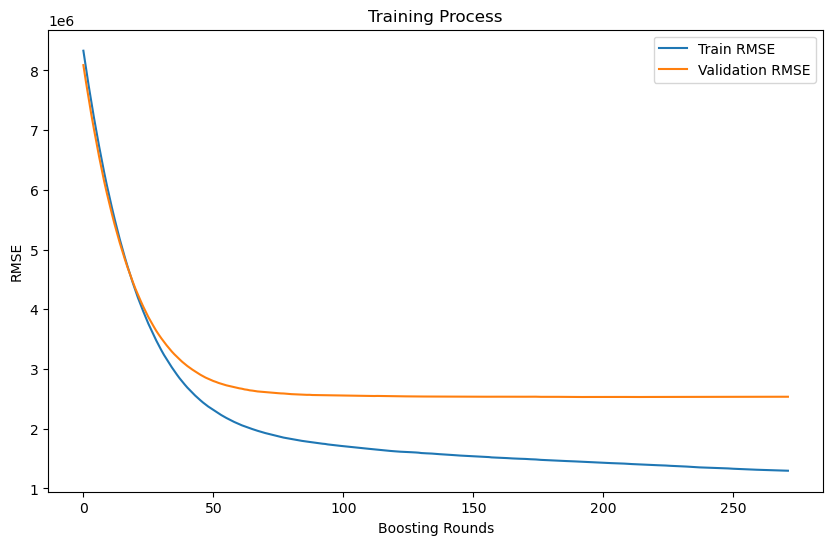

In [4]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test)

params = {
    'max_depth': 8,
    'learning_rate': 0.04,
    'booster': 'dart', # [gbtree, dart, gblinear]
    'tree_method': 'hist',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'random_state': 42
}

num_round = 400

history = {}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=80,
    verbose_eval=20,
    evals_result=history
)

train_rmse = history['train']['rmse']
val_rmse = history['val']['rmse']

predictions = model.predict(dtest)

rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training Process')
plt.legend()
plt.show()

In [34]:
# plot_importance(model)
# plt.show()

In [37]:
feature_importance = model.get_fscore()
feature_importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [43]:
feature_importance_df.iloc[:10]

,Feature,Importance
0,full_sq,4388.0
2,floor,2033.0
1,life_sq,2028.0
3,max_floor,1065.0
6,kitch_sq,913.0
71,kindergarten_km,643.0
67,metro_min_avto,499.0
85,public_transport_station_km,467.0
74,green_zone_km,459.0
5,num_room,450.0


In [14]:
params = {
    'max_depth': [6],
    'learning_rate': [0.05],
    'colsample_bytree': [0.8],
    'subsample': [0.8]
}

xgb_model = xgb.XGBRegressor(
    booster='gbtree',
    tree_method='hist',
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    n_estimators=600,
    early_stopping_rounds=80
)

# grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='neg_mean_squared_error', cv=5, verbose=2)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='r2', cv=5, verbose=2)

grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)])

print("Best Parameters:", grid_search.best_params_)
print("Best Negative R2:", grid_search.best_score_)


predictions = grid_search.predict(X_test)

rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0]	validation_0-rmse:8262493.20553	validation_1-rmse:8020172.57049
[1]	validation_0-rmse:7903967.68524	validation_1-rmse:7671795.24385
[2]	validation_0-rmse:7567124.13341	validation_1-rmse:7345688.39153
[3]	validation_0-rmse:7245435.65339	validation_1-rmse:7033277.91304
[4]	validation_0-rmse:6939777.74694	validation_1-rmse:6735947.94677
[5]	validation_0-rmse:6655534.25541	validation_1-rmse:6459074.76350
[6]	validation_0-rmse:6385002.82422	validation_1-rmse:6205672.57399
[7]	validation_0-rmse:6127897.49813	validation_1-rmse:5961050.01657
[8]	validation_0-rmse:5887975.96302	validation_1-rmse:5738735.63289
[9]	validation_0-rmse:5658020.15180	validation_1-rmse:5522133.90679
[10]	validation_0-rmse:5455101.67344	validation_1-rmse:5324644.69437
[11]	validation_0-rmse:5250962.07892	validation_1-rmse:5132417.71285
[12]	validation_0-rmse:5059904.12913	validation_1-rmse:4953154.78424
[13]	validation_0-rmse:4880420.02765	validation_1-rmse

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter space for random search
param_space = {
    'max_depth': np.arange(3, 10),
    'learning_rate': [0.05],
    'colsample_bytree': np.random.uniform(0.6, 1.0, 10),  # Generate 10 random values in [0.6, 1.0]
    'subsample': np.random.uniform(0.6, 1.0, 10)  # Generate 10 random values in [0.6, 1.0]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(
    booster='gbtree',
    tree_method='hist',
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    n_estimators=600,
    early_stopping_rounds=80
)

# Create RandomizedSearchCV instance
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_space,
    scoring='r2',
    cv=5,
    n_iter=50,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform random parameter search
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)])

print("Best Parameters:", random_search.best_params_)
print("Best R2:", random_search.best_score_)

predictions = random_search.predict(X_test)

rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)


In [45]:
import numpy as np

x = np.random.rand(1000, 1)

In [46]:
x.shape[0]

1000

In [47]:
for i in range(x.shape[0]):
    if x[i] < 0.5:
        x[i] = 0
    else:
        x[i] = 1


In [48]:
y = np.random.randint(0, 2, (1000,1))

In [51]:
from sklearn.metrics import classification_report, confusion_matrix


In [50]:
print(classification_report(y, x))

              precision    recall  f1-score   support

           0       0.47      0.49      0.48       493
           1       0.48      0.46      0.47       507

    accuracy                           0.48      1000
   macro avg       0.48      0.48      0.48      1000
weighted avg       0.48      0.48      0.48      1000



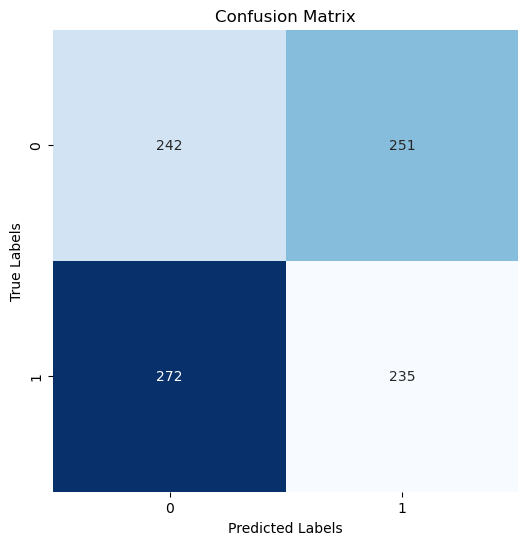

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y, x)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

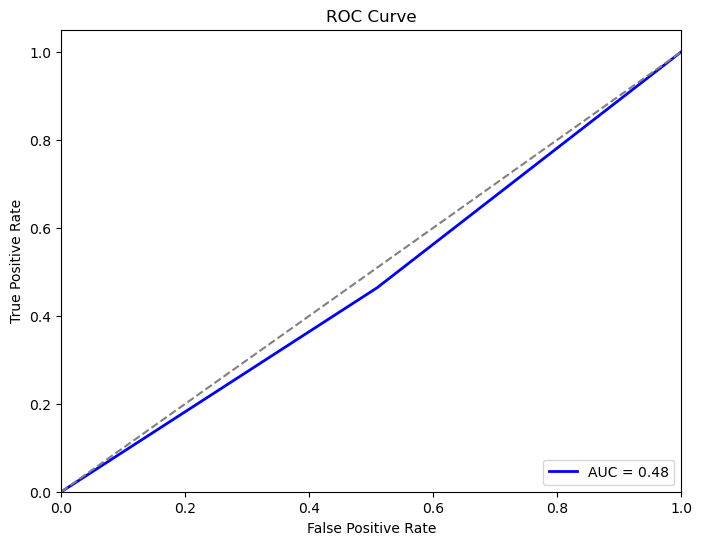

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y, x)
auc = roc_auc_score(y, x)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
